In [100]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import functional as TF
from PIL import Image
import os

class OxfordPetsSegmentationDataset(Dataset):
    def __init__(self, root_directory, split='train', image_size=128, max_samples=100):
        self.root_directory = root_directory
        self.image_size = image_size
        self.max_samples = max_samples
        self.dataset = OxfordIIITPet(
            root=root_directory,
            target_types='segmentation',
            download=True
        )
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        self.split = split
        self._filter_split()

    def _filter_split(self):
        dataset_length = len(self.dataset)
        if self.split == 'train':
            self.indices = list(range(0, min(self.max_samples, dataset_length // 2)))
        else:
            self.indices = list(range(dataset_length // 2, min(dataset_length // 2 + self.max_samples, dataset_length)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        actual_index = self.indices[index]
        image, segmentation_mask = self.dataset[actual_index]

        image = self.transform(image)
        segmentation_mask = TF.resize(segmentation_mask, (self.image_size, self.image_size), interpolation=Image.NEAREST)
        segmentation_mask = torch.as_tensor(np.array(segmentation_mask), dtype=torch.long)

        return image, segmentation_mask

def get_dataloaders(batch_size=8, image_size=128, max_samples=1000000, root_directory='./data'):
    train_dataset = OxfordPetsSegmentationDataset(root_directory, split='train', image_size=image_size, max_samples=max_samples)
    val_dataset = OxfordPetsSegmentationDataset(root_directory, split='val', image_size=image_size, max_samples=max_samples)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

    return train_loader, val_loader


In [101]:
train_loader, val_loader = get_dataloaders()

In [102]:
from torch import nn
import numpy as np
# class Unet(nn.Module):
#   def __init__(self, in_channels=3, layers=3, depth=3, channel_jumps=2, channel_start=64, num_classes_end=37):
#     super().__init__()
#     self.depth = depth
#     self.layers_count = layers
#     self.layers = nn.ModuleList()
#     for i in range(0, depth):
#       new_layer = nn.Conv2d(in_channels, channel_start, kernel_size=3, stride=1)
#       self.layers.append(new_layer)
#       relu = nn.ReLU()
#       self.layers.append(relu)
#       for j in range(1, layers):
#         new_layer = nn.Conv2d(channel_start, channel_start, kernel_size=3, stride=1)
#         self.layers.append(new_layer)
#         relu = nn.ReLU()
#         self.layers.append(relu)
#       new_layer = nn.MaxPool2d(kernel_size=2, stride=2)
#       self.layers.append(new_layer)
#       in_channels = channel_start
#       channel_start *= channel_jumps
#     for i in range(depth, 1, -1):
#       new_layer = nn.ConvTranspose2d(channel_start, channel_start // channel_jumps, kernel_size=2, stride=2)
#       self.layers.append(new_layer)
#       relu = nn.ReLU()
#       self.layers.append(relu)
#       for j in range(0, layers):
#         new_layer = nn.ConvTranspose2d(channel_start // channel_jumps, channel_start // channel_jumps, kernel_size=3, stride=1)
#         self.layers.append(new_layer)
#         relu = nn.ReLU()
#         self.layers.append(relu)
#       new_layer = nn.ConvTranspose2d(channel_start, channel_start // channel_jumps, kernel_size=2, stride=2)
#       self.layers.append(new_layer)
#       channel_start //= channel_jumps
#     new_layer = nn.Conv2d(channel_start, channel_start // channel_jumps, kernel_size=3, stride=1)
#     self.layers.append(new_layer)
#     relu = nn.ReLU()
#     self.layers.append(relu)
#     new_layer = nn.Conv2d(channel_start // channel_jumps, channel_start // channel_jumps, kernel_size=3, stride=1)
#     self.layers.append(new_layer)
#     new_layer = nn.Conv2d(channel_start // channel_jumps, num_classes_end, kernel_size=1, stride=1)
#     self.layers.append(new_layer)
#   def forward(self, x):
#     residual = []
#     for idx, layer in enumerate(self.layers):
#       if (idx <= len(self.layers) // 2) and (idx % (self.layers_count * 2) == 0):
#         x = layer(x)
#         residual.append(x)
#       elif (idx > len(self.layers) // 2) and layer.__class__.__name__ == 'ConvTranspose2d':
#         x = layer(x)
#         x += residual.pop()
#       else:
#         x = layer(x)
#     return x
def crop(tensor_to_crop, reference_tensor):
    _, _, h, w = reference_tensor.shape
    crop_h = (tensor_to_crop.shape[2] - h) // 2
    crop_w = (tensor_to_crop.shape[3] - w) // 2
    return tensor_to_crop[:, :, crop_h:crop_h + h, crop_w:crop_w + w]
class DownSampleBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
  def forward(self, x):
    return self.layers(x)
class UpSampleBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layers(x)
class Unet(nn.Module):
  def __init__(self, in_channels=3, layers=3, depth=3, channel_jumps=2, channel_start=64, num_classes_end=37):
    super().__init__()
    self.depth = depth
    self.layers = nn.ModuleList()
    dims_list = []
    for i in range(0, depth):
      new_layer = DownSampleBlock(in_channels, channel_start)
      self.layers.append(new_layer)
      in_channels = channel_start
      dims_list.append(channel_start)
      channel_start *= channel_jumps
    channel_start //= channel_jumps
    self.layers.append(nn.Conv2d(channel_start, channel_start, kernel_size=3, stride=1, padding=1))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.Conv2d(channel_start, channel_start, kernel_size=3, stride=1, padding=1))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.Conv2d(channel_start, channel_start, kernel_size=3, stride=1, padding=1))
    self.layers.append(nn.ReLU())
    for i in range(depth, 0, -1):
      new_layer = UpSampleBlock(channel_start + dims_list.pop(), channel_start // channel_jumps)
      self.layers.append(new_layer)
      channel_start //= channel_jumps
    # for i in range(depth, 0, -1):
    #   skip_channels = dims_list.pop()
    #   new_layer = UpSampleBlock(channel_start + skip_channels, skip_channels)
    #   self.layers.append(new_layer)
    #   channel_start = skip_channels

    self.layers.append(nn.Conv2d(channel_start, num_classes_end, kernel_size=1, stride=1))
  # def forward(self, x):
  #   first = True
  #   residual = []
  #   for layer in self.layers:
  #     if layer.__class__.__name__ == 'DownSampleBlock':
  #       x = layer(x)
  #       residual.append(x)
  #     elif layer.__class__.__name__ == 'UpSampleBlock':
  #       if first:
  #         first = False
  #         residual.pop()
  #       cropped_residual = crop(residual.pop(), x)
  #       x = torch.cat((x, cropped_residual), dim=1)
  #       x = layer(x)
  #     else:
  #       x = layer(x)
  #   return x
  def forward(self, x):
    first = True
    residual = []
    for layer in self.layers:
      if layer.__class__.__name__ == 'DownSampleBlock':
        x = layer(x)
        residual.append(x)
      elif layer.__class__.__name__ == 'UpSampleBlock':
        cropped_residual = crop(residual.pop(), x)
        x = torch.cat((x, cropped_residual), dim=1)
        x = layer(x)
      else:
        x = layer(x)
    return x

In [103]:
model = Unet()

In [104]:
from tqdm import tqdm
EPOCHS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
for epoch in range(0, EPOCHS):
  for image_batch, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
    #print(image_batch.shape)
    image_batch = image_batch.to(device)
    model_output = model(image_batch)
    output = loss(model_output, labels.to(device))
    print(output)
    output.backward()
    optimizer.step()
    optimizer.zero_grad()

  1%|▏         | 3/230 [00:00<00:24,  9.33it/s]

tensor(3.6451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.6158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.6013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 7/230 [00:00<00:15, 14.23it/s]

tensor(3.5776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.5259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.2044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.7022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 9/230 [00:00<00:14, 15.76it/s]

tensor(2.9181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.2798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.3262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.3342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.2718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 15/230 [00:00<00:11, 18.15it/s]

tensor(3.2143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.9825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.8120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:10, 19.22it/s]

tensor(2.3762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.0923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:10, 19.05it/s]

tensor(1.9955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.9314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.5284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.1755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 26/230 [00:01<00:10, 19.10it/s]

tensor(1.0770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.2559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.2271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 31/230 [00:01<00:10, 19.35it/s]

tensor(1.1194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 35/230 [00:02<00:09, 19.58it/s]

tensor(1.0652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 39/230 [00:02<00:09, 19.42it/s]

tensor(1.0132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 43/230 [00:02<00:09, 19.52it/s]

tensor(0.9556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 47/230 [00:02<00:09, 19.41it/s]

tensor(0.9697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 51/230 [00:02<00:09, 19.51it/s]

tensor(0.9584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 55/230 [00:03<00:09, 19.44it/s]

tensor(0.9725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 60/230 [00:03<00:08, 19.09it/s]

tensor(0.9265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 63/230 [00:03<00:08, 19.33it/s]

tensor(0.9484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 67/230 [00:03<00:08, 19.31it/s]

tensor(1.0092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 71/230 [00:03<00:08, 19.25it/s]

tensor(1.0257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9462, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 75/230 [00:04<00:08, 19.33it/s]

tensor(0.9597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0129, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 80/230 [00:04<00:07, 19.37it/s]

tensor(0.8233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 84/230 [00:04<00:07, 19.03it/s]

tensor(0.9177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 88/230 [00:04<00:07, 19.16it/s]

tensor(0.9207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8512, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 90/230 [00:04<00:07, 18.75it/s]

tensor(0.9970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 95/230 [00:05<00:07, 19.23it/s]

tensor(0.8117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.7700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.2580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 99/230 [00:05<00:07, 18.56it/s]

tensor(1.3405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.2944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.4056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.3865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 103/230 [00:05<00:07, 17.91it/s]

tensor(1.3531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.4046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.3142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.2972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 107/230 [00:05<00:07, 15.67it/s]

tensor(1.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.1826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 109/230 [00:05<00:07, 16.28it/s]

tensor(1.1435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 111/230 [00:06<00:08, 14.79it/s]

tensor(0.9974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 115/230 [00:06<00:08, 12.97it/s]

tensor(0.9775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 117/230 [00:06<00:08, 13.30it/s]

tensor(0.9525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 121/230 [00:06<00:08, 13.10it/s]

tensor(0.9934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 125/230 [00:07<00:07, 14.75it/s]

tensor(0.7861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 129/230 [00:07<00:06, 15.06it/s]

tensor(0.9950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 131/230 [00:07<00:06, 15.31it/s]

tensor(0.9168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8845, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 137/230 [00:07<00:05, 15.70it/s]

tensor(0.8137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9838, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 139/230 [00:08<00:05, 16.33it/s]

tensor(0.9614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 144/230 [00:08<00:04, 17.81it/s]

tensor(0.9400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 149/230 [00:08<00:04, 18.84it/s]

tensor(0.9360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 153/230 [00:08<00:04, 19.06it/s]

tensor(0.9670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 157/230 [00:09<00:03, 19.33it/s]

tensor(0.9260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 159/230 [00:09<00:03, 19.30it/s]

tensor(0.8801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 164/230 [00:09<00:03, 19.45it/s]

tensor(0.9555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 168/230 [00:09<00:03, 19.13it/s]

tensor(0.9245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 172/230 [00:09<00:03, 19.15it/s]

tensor(0.9239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 176/230 [00:09<00:02, 19.37it/s]

tensor(0.9011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 180/230 [00:10<00:02, 19.45it/s]

tensor(0.8987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 184/230 [00:10<00:02, 18.68it/s]

tensor(0.9690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 189/230 [00:10<00:02, 19.40it/s]

tensor(0.8686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 193/230 [00:10<00:01, 19.40it/s]

tensor(0.9005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 197/230 [00:11<00:01, 19.53it/s]

tensor(0.8453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 201/230 [00:11<00:01, 19.61it/s]

tensor(0.8610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 205/230 [00:11<00:01, 19.24it/s]

tensor(0.9228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 209/230 [00:11<00:01, 19.35it/s]

tensor(0.9171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 213/230 [00:11<00:00, 19.13it/s]

tensor(0.8677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 217/230 [00:12<00:00, 19.37it/s]

tensor(0.7572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9417, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 221/230 [00:12<00:00, 19.50it/s]

tensor(0.8328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 225/230 [00:12<00:00, 19.46it/s]

tensor(0.6795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 228/230 [00:12<00:00, 19.61it/s]

tensor(0.9098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.3264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:12<00:00, 17.96it/s]


tensor(1.0204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 1/230 [00:00<00:36,  6.32it/s]

tensor(0.7997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 3/230 [00:00<00:17, 12.67it/s]

tensor(0.8742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 5/230 [00:00<00:14, 15.09it/s]

tensor(0.8741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:13, 16.89it/s]

tensor(0.8634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 11/230 [00:00<00:12, 17.94it/s]

tensor(0.8126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 13/230 [00:00<00:11, 18.15it/s]

tensor(0.9049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 16/230 [00:00<00:11, 18.80it/s]

tensor(0.9555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:11, 18.71it/s]

tensor(0.8413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:10, 19.09it/s]

tensor(0.8310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 28/230 [00:01<00:10, 19.30it/s]

tensor(0.7030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7966, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 32/230 [00:01<00:10, 19.30it/s]

tensor(0.8725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 36/230 [00:01<00:10, 19.38it/s]

tensor(0.7863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 40/230 [00:02<00:09, 19.26it/s]

tensor(0.8128, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(1.0085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 44/230 [00:02<00:09, 19.40it/s]

tensor(0.8606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 48/230 [00:02<00:09, 19.37it/s]

tensor(0.7972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 52/230 [00:02<00:09, 19.10it/s]

tensor(0.8273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 56/230 [00:03<00:09, 19.19it/s]

tensor(0.8649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 60/230 [00:03<00:08, 19.21it/s]

tensor(0.7796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 64/230 [00:03<00:08, 19.36it/s]

tensor(0.7166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 68/230 [00:03<00:08, 19.39it/s]

tensor(0.6630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 72/230 [00:03<00:08, 18.75it/s]

tensor(0.7124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 76/230 [00:04<00:08, 18.85it/s]

tensor(0.6420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 80/230 [00:04<00:07, 19.12it/s]

tensor(0.7847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7487, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 84/230 [00:04<00:07, 19.27it/s]

tensor(0.7089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 88/230 [00:04<00:07, 19.34it/s]

tensor(0.7247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 92/230 [00:04<00:07, 19.25it/s]

tensor(0.7884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 96/230 [00:05<00:07, 18.29it/s]

tensor(0.7490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 100/230 [00:05<00:07, 17.96it/s]

tensor(0.7101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 102/230 [00:05<00:07, 18.26it/s]

tensor(0.8662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 104/230 [00:05<00:07, 16.79it/s]

tensor(0.7850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 106/230 [00:05<00:07, 17.30it/s]

tensor(0.9336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 108/230 [00:05<00:07, 16.54it/s]

tensor(0.8659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 110/230 [00:05<00:07, 15.39it/s]

tensor(0.8549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 112/230 [00:06<00:07, 15.65it/s]

tensor(0.7864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 114/230 [00:06<00:07, 15.32it/s]

tensor(0.7275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 116/230 [00:06<00:07, 14.85it/s]

tensor(0.6932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 118/230 [00:06<00:07, 15.05it/s]

tensor(0.7459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 120/230 [00:06<00:07, 14.79it/s]

tensor(0.6769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 122/230 [00:06<00:07, 14.09it/s]

tensor(0.7945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 124/230 [00:06<00:07, 13.66it/s]

tensor(0.7231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 126/230 [00:07<00:07, 13.23it/s]

tensor(0.8349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 128/230 [00:07<00:06, 14.58it/s]

tensor(0.7252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 130/230 [00:07<00:07, 14.20it/s]

tensor(0.6776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 132/230 [00:07<00:06, 15.22it/s]

tensor(0.6372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 134/230 [00:07<00:07, 13.16it/s]

tensor(0.5926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 138/230 [00:08<00:08, 11.18it/s]

tensor(0.6860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 142/230 [00:08<00:06, 13.53it/s]

tensor(0.8327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 146/230 [00:08<00:05, 15.53it/s]

tensor(0.8263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8193, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 150/230 [00:08<00:04, 17.00it/s]

tensor(0.7446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 152/230 [00:08<00:04, 16.26it/s]

tensor(0.8761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7096, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 156/230 [00:09<00:05, 13.24it/s]

tensor(0.7042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 160/230 [00:09<00:04, 15.59it/s]

tensor(0.6894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7129, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 164/230 [00:09<00:03, 16.62it/s]

tensor(0.6457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 168/230 [00:09<00:03, 17.33it/s]

tensor(0.6238, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 170/230 [00:10<00:03, 16.79it/s]

tensor(0.7571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 174/230 [00:10<00:03, 15.79it/s]

tensor(0.6547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 178/230 [00:10<00:03, 17.06it/s]

tensor(0.7730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6919, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 182/230 [00:10<00:02, 18.25it/s]

tensor(0.6171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 186/230 [00:10<00:02, 18.64it/s]

tensor(0.7374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 190/230 [00:11<00:02, 18.35it/s]

tensor(0.7715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 194/230 [00:11<00:01, 18.55it/s]

tensor(0.8051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 198/230 [00:11<00:01, 19.13it/s]

tensor(0.9055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 202/230 [00:11<00:01, 19.25it/s]

tensor(0.7805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9408, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 206/230 [00:12<00:01, 18.58it/s]

tensor(0.9230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 210/230 [00:12<00:01, 18.75it/s]

tensor(0.7512, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 215/230 [00:12<00:00, 19.02it/s]

tensor(0.7215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 219/230 [00:12<00:00, 18.97it/s]

tensor(0.6135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 223/230 [00:12<00:00, 19.02it/s]

tensor(0.7412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 227/230 [00:13<00:00, 18.98it/s]

tensor(0.8102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:13<00:00, 17.21it/s]


tensor(0.8515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 3/230 [00:00<00:19, 11.70it/s]

tensor(0.7404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 7/230 [00:00<00:15, 14.63it/s]

tensor(0.6740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 11/230 [00:00<00:13, 16.03it/s]

tensor(0.7652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 15/230 [00:01<00:14, 14.41it/s]

tensor(0.6606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 17/230 [00:01<00:15, 14.15it/s]

tensor(0.7368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 21/230 [00:01<00:15, 13.57it/s]

tensor(0.7892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 23/230 [00:01<00:15, 13.60it/s]

tensor(0.7762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 25/230 [00:01<00:15, 12.84it/s]

tensor(0.7039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 29/230 [00:02<00:16, 12.07it/s]

tensor(0.6147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 31/230 [00:02<00:17, 11.50it/s]

tensor(0.7511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6803, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 33/230 [00:02<00:17, 11.47it/s]

tensor(0.6217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 37/230 [00:02<00:16, 11.59it/s]

tensor(0.6353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 41/230 [00:03<00:13, 13.68it/s]

tensor(0.7017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 43/230 [00:03<00:13, 13.96it/s]

tensor(0.7072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 47/230 [00:03<00:13, 13.49it/s]

tensor(0.7826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 49/230 [00:03<00:13, 13.29it/s]

tensor(0.8177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 53/230 [00:04<00:14, 12.39it/s]

tensor(0.6582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 59/230 [00:04<00:11, 15.42it/s]

tensor(0.7758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 61/230 [00:04<00:10, 15.80it/s]

tensor(0.8265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 65/230 [00:05<00:15, 10.99it/s]

tensor(0.6946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 67/230 [00:05<00:18,  8.89it/s]

tensor(0.6963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 69/230 [00:05<00:17,  9.07it/s]

tensor(0.6849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 71/230 [00:05<00:19,  8.10it/s]

tensor(0.6748, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 74/230 [00:06<00:16,  9.48it/s]

tensor(0.7671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 78/230 [00:06<00:13, 11.47it/s]

tensor(0.6923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 82/230 [00:06<00:11, 13.36it/s]

tensor(0.6820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 86/230 [00:06<00:09, 15.37it/s]

tensor(0.7565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 90/230 [00:07<00:10, 13.12it/s]

tensor(0.8114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 94/230 [00:07<00:09, 14.10it/s]

tensor(0.7370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7984, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 99/230 [00:07<00:07, 16.87it/s]

tensor(0.6649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 103/230 [00:08<00:07, 17.50it/s]

tensor(0.7419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 107/230 [00:08<00:06, 17.78it/s]

tensor(0.7876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 111/230 [00:08<00:06, 17.91it/s]

tensor(0.6537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 115/230 [00:08<00:06, 18.64it/s]

tensor(0.6881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 119/230 [00:08<00:05, 19.03it/s]

tensor(0.7192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7087, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 123/230 [00:09<00:06, 17.29it/s]

tensor(0.9020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 125/230 [00:09<00:06, 17.22it/s]

tensor(0.8177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 129/230 [00:09<00:06, 15.17it/s]

tensor(0.7200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 133/230 [00:09<00:05, 16.26it/s]

tensor(0.7176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 137/230 [00:10<00:05, 17.34it/s]

tensor(0.6602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 141/230 [00:10<00:04, 18.12it/s]

tensor(0.6482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 145/230 [00:10<00:04, 18.30it/s]

tensor(0.6055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 149/230 [00:10<00:04, 18.62it/s]

tensor(0.5760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 153/230 [00:10<00:04, 18.94it/s]

tensor(0.6969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6502, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 157/230 [00:11<00:03, 18.72it/s]

tensor(0.7321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 161/230 [00:11<00:03, 17.79it/s]

tensor(0.5943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 165/230 [00:11<00:03, 16.78it/s]

tensor(0.6516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 167/230 [00:11<00:04, 14.48it/s]

tensor(0.6872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 171/230 [00:12<00:04, 13.06it/s]

tensor(0.7283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 175/230 [00:12<00:03, 15.48it/s]

tensor(0.6364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 179/230 [00:12<00:02, 17.17it/s]

tensor(0.5759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 183/230 [00:12<00:02, 17.73it/s]

tensor(0.6225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 187/230 [00:12<00:02, 17.16it/s]

tensor(0.5885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 191/230 [00:13<00:02, 18.12it/s]

tensor(0.7159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 196/230 [00:13<00:01, 18.82it/s]

tensor(0.7137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 200/230 [00:13<00:01, 18.77it/s]

tensor(0.7676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 204/230 [00:13<00:01, 18.69it/s]

tensor(0.7520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 208/230 [00:14<00:01, 18.80it/s]

tensor(0.6370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 211/230 [00:14<00:00, 19.21it/s]

tensor(0.6184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 215/230 [00:14<00:00, 18.68it/s]

tensor(0.6037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 219/230 [00:14<00:00, 16.16it/s]

tensor(0.7154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 223/230 [00:14<00:00, 16.37it/s]

tensor(0.6592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 227/230 [00:15<00:00, 17.49it/s]

tensor(0.7538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:15<00:00, 14.96it/s]


tensor(0.6919, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:17, 13.09it/s]

tensor(0.6005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:13, 16.07it/s]

tensor(0.6160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6782, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 12/230 [00:00<00:13, 16.34it/s]

tensor(0.6428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 14/230 [00:00<00:14, 14.94it/s]

tensor(0.5817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:14, 14.45it/s]

tensor(0.7643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:12, 16.65it/s]

tensor(0.7212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 28/230 [00:01<00:11, 17.98it/s]

tensor(0.6641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 32/230 [00:02<00:10, 18.20it/s]

tensor(0.5503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 36/230 [00:02<00:11, 17.38it/s]

tensor(0.8053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 40/230 [00:02<00:10, 18.01it/s]

tensor(0.6007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 44/230 [00:02<00:10, 17.34it/s]

tensor(0.6395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 46/230 [00:02<00:11, 16.24it/s]

tensor(0.7511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 50/230 [00:03<00:11, 15.07it/s]

tensor(0.6414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 52/230 [00:03<00:12, 14.51it/s]

tensor(0.8281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 56/230 [00:03<00:12, 14.29it/s]

tensor(0.6795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6842, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 58/230 [00:03<00:13, 12.60it/s]

tensor(0.9288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 62/230 [00:04<00:12, 13.89it/s]

tensor(0.6390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 66/230 [00:04<00:11, 14.40it/s]

tensor(0.7480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 68/230 [00:04<00:11, 13.84it/s]

tensor(0.7112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 72/230 [00:04<00:10, 15.06it/s]

tensor(0.7495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 76/230 [00:04<00:10, 14.58it/s]

tensor(0.6746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 80/230 [00:05<00:09, 16.39it/s]

tensor(0.7029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6534, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 85/230 [00:05<00:08, 18.03it/s]

tensor(0.6049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 89/230 [00:05<00:07, 17.98it/s]

tensor(0.6038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 93/230 [00:05<00:07, 18.46it/s]

tensor(0.7497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 95/230 [00:05<00:07, 18.70it/s]

tensor(0.6744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 101/230 [00:06<00:06, 19.36it/s]

tensor(0.7589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 105/230 [00:06<00:06, 19.12it/s]

tensor(0.5762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6291, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 109/230 [00:06<00:06, 17.32it/s]

tensor(0.7382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 113/230 [00:06<00:06, 17.98it/s]

tensor(0.6642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 118/230 [00:07<00:06, 18.32it/s]

tensor(0.7348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 122/230 [00:07<00:05, 18.63it/s]

tensor(0.7210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 126/230 [00:07<00:05, 18.85it/s]

tensor(0.7049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 130/230 [00:07<00:05, 19.02it/s]

tensor(0.7025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6598, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 134/230 [00:08<00:05, 19.13it/s]

tensor(0.6140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 138/230 [00:08<00:04, 19.10it/s]

tensor(0.6313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 142/230 [00:08<00:04, 18.77it/s]

tensor(0.7965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 146/230 [00:08<00:04, 19.04it/s]

tensor(0.6366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 150/230 [00:08<00:04, 19.23it/s]

tensor(0.7346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 154/230 [00:09<00:03, 19.01it/s]

tensor(0.7075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 158/230 [00:09<00:03, 19.05it/s]

tensor(0.6090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 162/230 [00:09<00:03, 19.11it/s]

tensor(0.5928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 164/230 [00:09<00:03, 18.75it/s]

tensor(0.6277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 169/230 [00:09<00:03, 19.15it/s]

tensor(0.6974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5782, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 173/230 [00:10<00:02, 19.24it/s]

tensor(0.6484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6023, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 177/230 [00:10<00:02, 19.23it/s]

tensor(0.6637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 182/230 [00:10<00:02, 19.36it/s]

tensor(0.7255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 186/230 [00:10<00:02, 18.68it/s]

tensor(0.6557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 190/230 [00:11<00:02, 18.77it/s]

tensor(0.6788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 194/230 [00:11<00:01, 18.00it/s]

tensor(0.5566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 198/230 [00:11<00:01, 18.37it/s]

tensor(0.6905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 200/230 [00:11<00:01, 18.04it/s]

tensor(0.6244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 206/230 [00:11<00:01, 17.58it/s]

tensor(0.7184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 210/230 [00:12<00:01, 18.00it/s]

tensor(0.6957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 214/230 [00:12<00:00, 18.61it/s]

tensor(0.7431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 218/230 [00:12<00:00, 18.46it/s]

tensor(0.6423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 222/230 [00:12<00:00, 18.96it/s]

tensor(0.5982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 226/230 [00:13<00:00, 19.26it/s]

tensor(0.8006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6023, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:13<00:00, 17.36it/s]


tensor(0.7178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:16, 13.62it/s]

tensor(0.5985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:13, 16.32it/s]

tensor(0.7098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 12/230 [00:00<00:12, 18.04it/s]

tensor(0.6566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 16/230 [00:00<00:11, 18.75it/s]

tensor(0.5190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:11, 18.68it/s]

tensor(0.7737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5609, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:11, 18.50it/s]

tensor(0.7217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 26/230 [00:01<00:10, 18.72it/s]

tensor(0.5583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 31/230 [00:01<00:10, 19.10it/s]

tensor(0.7519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 35/230 [00:01<00:10, 18.34it/s]

tensor(0.6223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 39/230 [00:02<00:10, 18.89it/s]

tensor(0.7799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 43/230 [00:02<00:11, 15.87it/s]

tensor(0.6251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 45/230 [00:02<00:11, 15.50it/s]

tensor(0.6420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 49/230 [00:02<00:13, 13.72it/s]

tensor(0.7296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 51/230 [00:03<00:12, 14.46it/s]

tensor(0.7035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 55/230 [00:03<00:13, 13.39it/s]

tensor(0.5761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 57/230 [00:03<00:12, 13.43it/s]

tensor(0.8310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 61/230 [00:03<00:12, 13.98it/s]

tensor(0.6989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 63/230 [00:03<00:11, 14.02it/s]

tensor(0.5389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 67/230 [00:04<00:11, 14.25it/s]

tensor(0.7236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 71/230 [00:04<00:10, 15.09it/s]

tensor(0.5900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 73/230 [00:04<00:10, 15.45it/s]

tensor(0.5596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 77/230 [00:04<00:09, 15.91it/s]

tensor(0.6935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 81/230 [00:05<00:08, 17.35it/s]

tensor(0.5546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 85/230 [00:05<00:07, 18.28it/s]

tensor(0.7065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 89/230 [00:05<00:07, 18.42it/s]

tensor(0.6340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 94/230 [00:05<00:07, 18.98it/s]

tensor(0.6737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 99/230 [00:06<00:06, 19.50it/s]

tensor(0.7357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7304, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 103/230 [00:06<00:06, 19.28it/s]

tensor(0.6227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 107/230 [00:06<00:06, 19.36it/s]

tensor(0.5822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 111/230 [00:06<00:06, 19.45it/s]

tensor(0.6429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 113/230 [00:06<00:06, 18.66it/s]

tensor(0.9195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 118/230 [00:07<00:05, 19.34it/s]

tensor(0.5777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 122/230 [00:07<00:05, 19.41it/s]

tensor(0.5691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 127/230 [00:07<00:05, 19.61it/s]

tensor(0.5671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 131/230 [00:07<00:05, 18.62it/s]

tensor(0.6295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6387, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 135/230 [00:07<00:05, 18.18it/s]

tensor(0.5386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 139/230 [00:08<00:04, 18.69it/s]

tensor(0.6466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 143/230 [00:08<00:04, 19.09it/s]

tensor(0.5364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 147/230 [00:08<00:04, 18.92it/s]

tensor(0.5506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 149/230 [00:08<00:04, 18.77it/s]

tensor(0.6336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4988, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 154/230 [00:08<00:03, 19.33it/s]

tensor(0.6754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 158/230 [00:09<00:03, 19.19it/s]

tensor(0.6693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 163/230 [00:09<00:03, 19.23it/s]

tensor(0.6777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 167/230 [00:09<00:03, 19.17it/s]

tensor(0.6963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 171/230 [00:09<00:03, 19.17it/s]

tensor(0.7328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 176/230 [00:10<00:02, 19.58it/s]

tensor(0.7009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 178/230 [00:10<00:02, 19.00it/s]

tensor(0.6145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5785, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 183/230 [00:10<00:02, 19.36it/s]

tensor(0.6250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 187/230 [00:10<00:02, 17.89it/s]

tensor(0.6993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 192/230 [00:10<00:01, 19.02it/s]

tensor(0.7326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 196/230 [00:11<00:01, 19.26it/s]

tensor(0.8996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 201/230 [00:11<00:01, 19.39it/s]

tensor(0.5766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 205/230 [00:11<00:01, 18.76it/s]

tensor(0.7016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 208/230 [00:11<00:01, 19.14it/s]

tensor(0.6767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 214/230 [00:12<00:00, 19.17it/s]

tensor(0.5633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 219/230 [00:12<00:00, 19.18it/s]

tensor(0.6857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 223/230 [00:12<00:00, 19.32it/s]

tensor(0.5428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 227/230 [00:12<00:00, 18.60it/s]

tensor(0.6269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:12<00:00, 17.78it/s]


tensor(0.6121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:16, 13.91it/s]

tensor(0.5400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:13, 16.67it/s]

tensor(0.7082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5087, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 11/230 [00:00<00:12, 18.00it/s]

tensor(0.6746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 16/230 [00:00<00:11, 18.83it/s]

tensor(0.5802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:11, 18.83it/s]

tensor(0.5439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 23/230 [00:01<00:10, 19.18it/s]

tensor(0.5707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 27/230 [00:01<00:10, 19.40it/s]

tensor(0.6220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 32/230 [00:01<00:10, 19.66it/s]

tensor(0.6122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.9081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 36/230 [00:01<00:10, 18.81it/s]

tensor(0.6628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 40/230 [00:02<00:10, 18.22it/s]

tensor(0.4979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5598, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 42/230 [00:02<00:11, 16.83it/s]

tensor(0.5585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 47/230 [00:02<00:11, 16.06it/s]

tensor(0.5324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 51/230 [00:02<00:10, 16.35it/s]

tensor(0.5137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 55/230 [00:03<00:11, 15.78it/s]

tensor(0.7684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 59/230 [00:03<00:11, 15.33it/s]

tensor(0.6636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 61/230 [00:03<00:12, 14.05it/s]

tensor(0.8752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 65/230 [00:03<00:12, 13.27it/s]

tensor(0.7076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 69/230 [00:04<00:11, 14.54it/s]

tensor(0.6071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5895, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 73/230 [00:04<00:09, 16.26it/s]

tensor(0.6184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 77/230 [00:04<00:10, 15.15it/s]

tensor(0.4968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 79/230 [00:04<00:10, 14.85it/s]

tensor(0.5852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 83/230 [00:05<00:09, 15.87it/s]

tensor(0.6798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 87/230 [00:05<00:08, 17.06it/s]

tensor(0.6623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 91/230 [00:05<00:07, 18.22it/s]

tensor(0.6613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 96/230 [00:05<00:07, 18.83it/s]

tensor(0.6846, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 100/230 [00:05<00:06, 19.10it/s]

tensor(0.5798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 105/230 [00:06<00:06, 19.34it/s]

tensor(0.7529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 108/230 [00:06<00:06, 19.65it/s]

tensor(0.5911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 113/230 [00:06<00:05, 19.52it/s]

tensor(0.6583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 118/230 [00:06<00:05, 19.76it/s]

tensor(0.4924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 122/230 [00:07<00:05, 19.34it/s]

tensor(0.4991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 127/230 [00:07<00:05, 19.60it/s]

tensor(0.6822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 131/230 [00:07<00:05, 18.93it/s]

tensor(0.5692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 135/230 [00:07<00:05, 18.52it/s]

tensor(0.6401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 139/230 [00:08<00:05, 17.21it/s]

tensor(0.4829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5539, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 143/230 [00:08<00:05, 15.80it/s]

tensor(0.8197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 145/230 [00:08<00:05, 15.10it/s]

tensor(0.6697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 149/230 [00:08<00:05, 13.82it/s]

tensor(0.6549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 153/230 [00:09<00:05, 13.96it/s]

tensor(0.7040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 155/230 [00:09<00:05, 13.75it/s]

tensor(0.5167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 157/230 [00:09<00:05, 13.85it/s]

tensor(0.4246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 161/230 [00:09<00:05, 12.88it/s]

tensor(0.5099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 163/230 [00:09<00:04, 13.52it/s]

tensor(0.6370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 167/230 [00:10<00:04, 13.84it/s]

tensor(0.8963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 171/230 [00:10<00:03, 16.15it/s]

tensor(0.5439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 175/230 [00:10<00:03, 17.22it/s]

tensor(0.6081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 178/230 [00:10<00:02, 18.33it/s]

tensor(0.6366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 183/230 [00:10<00:02, 18.32it/s]

tensor(0.5437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 188/230 [00:11<00:02, 19.29it/s]

tensor(0.5940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 192/230 [00:11<00:01, 19.35it/s]

tensor(0.5865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 195/230 [00:11<00:01, 19.26it/s]

tensor(0.5976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 200/230 [00:11<00:01, 19.65it/s]

tensor(0.4298, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 204/230 [00:12<00:01, 19.26it/s]

tensor(0.5186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 208/230 [00:12<00:01, 18.98it/s]

tensor(0.5239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 213/230 [00:12<00:00, 19.47it/s]

tensor(0.6698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 218/230 [00:12<00:00, 19.50it/s]

tensor(0.6419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 222/230 [00:12<00:00, 19.26it/s]

tensor(0.6327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6751, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 224/230 [00:13<00:00, 19.25it/s]

tensor(0.5770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:13<00:00, 17.18it/s]


tensor(0.7249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:16, 13.81it/s]

tensor(0.5896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 9/230 [00:00<00:12, 17.59it/s]

tensor(0.4671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 13/230 [00:00<00:11, 18.22it/s]

tensor(0.5533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6096, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 17/230 [00:00<00:11, 18.93it/s]

tensor(0.4625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 21/230 [00:01<00:11, 18.32it/s]

tensor(0.4627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 23/230 [00:01<00:11, 18.62it/s]

tensor(0.7556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 29/230 [00:01<00:10, 19.32it/s]

tensor(0.6059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 33/230 [00:01<00:10, 18.67it/s]

tensor(0.5554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 37/230 [00:02<00:10, 19.00it/s]

tensor(0.5832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4988, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 41/230 [00:02<00:11, 16.26it/s]

tensor(0.5422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 43/230 [00:02<00:11, 15.85it/s]

tensor(0.5195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 47/230 [00:02<00:13, 13.74it/s]

tensor(0.5994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 49/230 [00:02<00:13, 13.77it/s]

tensor(0.5520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 53/230 [00:03<00:14, 12.48it/s]

tensor(0.7244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 55/230 [00:03<00:13, 13.15it/s]

tensor(0.5399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 59/230 [00:03<00:12, 13.79it/s]

tensor(0.5913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 63/230 [00:03<00:11, 14.82it/s]

tensor(0.4693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 69/230 [00:04<00:10, 14.75it/s]

tensor(0.6517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 73/230 [00:04<00:09, 16.35it/s]

tensor(0.6000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5842, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 77/230 [00:04<00:08, 17.87it/s]

tensor(0.5848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 81/230 [00:05<00:08, 18.22it/s]

tensor(0.4494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 83/230 [00:05<00:08, 18.20it/s]

tensor(0.6130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 89/230 [00:05<00:07, 19.20it/s]

tensor(0.4899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 94/230 [00:05<00:06, 19.64it/s]

tensor(0.4797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 99/230 [00:05<00:06, 19.66it/s]

tensor(0.5334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 103/230 [00:06<00:06, 19.52it/s]

tensor(0.7986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4387, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 107/230 [00:06<00:06, 19.24it/s]

tensor(0.6208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 112/230 [00:06<00:06, 19.43it/s]

tensor(0.5293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 117/230 [00:06<00:05, 19.68it/s]

tensor(0.7330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 121/230 [00:07<00:05, 19.44it/s]

tensor(0.6600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5598, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 125/230 [00:07<00:05, 19.59it/s]

tensor(0.4604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 129/230 [00:07<00:05, 19.71it/s]

tensor(0.6215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 133/230 [00:07<00:05, 18.21it/s]

tensor(0.6376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 136/230 [00:07<00:04, 19.37it/s]

tensor(0.9523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 140/230 [00:08<00:04, 18.38it/s]

tensor(0.6024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 145/230 [00:08<00:04, 19.14it/s]

tensor(0.4725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 149/230 [00:08<00:04, 18.94it/s]

tensor(0.5680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 152/230 [00:08<00:04, 19.30it/s]

tensor(0.6046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 156/230 [00:08<00:03, 19.41it/s]

tensor(0.4036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 160/230 [00:09<00:03, 19.08it/s]

tensor(0.5637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 164/230 [00:09<00:03, 19.02it/s]

tensor(0.5330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 168/230 [00:09<00:03, 18.94it/s]

tensor(0.4763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 171/230 [00:09<00:03, 18.72it/s]

tensor(0.6005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 176/230 [00:09<00:02, 19.12it/s]

tensor(0.5616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 181/230 [00:10<00:02, 19.67it/s]

tensor(0.5946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 186/230 [00:10<00:02, 19.60it/s]

tensor(0.6520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 190/230 [00:10<00:02, 19.48it/s]

tensor(0.5701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 192/230 [00:10<00:02, 18.89it/s]

tensor(0.4990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 197/230 [00:11<00:01, 19.21it/s]

tensor(0.5572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 202/230 [00:11<00:01, 19.46it/s]

tensor(0.5108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 206/230 [00:11<00:01, 19.33it/s]

tensor(0.5647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 210/230 [00:11<00:01, 19.28it/s]

tensor(0.4489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 214/230 [00:11<00:00, 19.37it/s]

tensor(0.5831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 216/230 [00:12<00:00, 19.44it/s]

tensor(0.7279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 221/230 [00:12<00:00, 19.36it/s]

tensor(0.5310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 225/230 [00:12<00:00, 19.23it/s]

tensor(0.5139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:12<00:00, 17.99it/s]


tensor(0.5667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:16, 13.39it/s]

tensor(0.5494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:13, 16.75it/s]

tensor(0.5000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 12/230 [00:00<00:12, 17.18it/s]

tensor(0.5397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 17/230 [00:01<00:11, 18.30it/s]

tensor(0.8040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 19/230 [00:01<00:11, 17.99it/s]

tensor(0.5372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:10, 18.87it/s]

tensor(0.6339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 29/230 [00:01<00:10, 19.28it/s]

tensor(0.5234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 33/230 [00:01<00:10, 18.82it/s]

tensor(0.4286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 37/230 [00:02<00:10, 18.18it/s]

tensor(0.6173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 41/230 [00:02<00:12, 15.23it/s]

tensor(0.5576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 43/230 [00:02<00:12, 14.81it/s]

tensor(0.4105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 47/230 [00:02<00:13, 13.43it/s]

tensor(0.5569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4719, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 49/230 [00:02<00:12, 14.33it/s]

tensor(0.4801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 53/230 [00:03<00:13, 13.42it/s]

tensor(0.5308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 55/230 [00:03<00:13, 13.35it/s]

tensor(0.4996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 59/230 [00:03<00:11, 14.78it/s]

tensor(0.4952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 63/230 [00:03<00:10, 15.46it/s]

tensor(0.5024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 67/230 [00:04<00:09, 16.99it/s]

tensor(0.5114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 71/230 [00:04<00:10, 15.57it/s]

tensor(0.4913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 75/230 [00:04<00:09, 16.22it/s]

tensor(0.5429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 79/230 [00:04<00:08, 16.93it/s]

tensor(0.5829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 83/230 [00:05<00:08, 17.93it/s]

tensor(0.4403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 85/230 [00:05<00:08, 17.80it/s]

tensor(0.4970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 91/230 [00:05<00:07, 18.43it/s]

tensor(0.4963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 95/230 [00:05<00:07, 18.85it/s]

tensor(0.6496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 99/230 [00:05<00:07, 18.29it/s]

tensor(0.5771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 102/230 [00:06<00:06, 19.05it/s]

tensor(0.5466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 106/230 [00:06<00:06, 18.92it/s]

tensor(0.4442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 110/230 [00:06<00:06, 19.03it/s]

tensor(0.5794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 114/230 [00:06<00:05, 19.36it/s]

tensor(0.4196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5678, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 119/230 [00:07<00:05, 19.64it/s]

tensor(0.5202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5803, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 123/230 [00:07<00:05, 19.00it/s]

tensor(0.6308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 127/230 [00:07<00:05, 19.46it/s]

tensor(0.7583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 131/230 [00:07<00:05, 19.37it/s]

tensor(0.5138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 133/230 [00:07<00:05, 19.27it/s]

tensor(0.4892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 139/230 [00:08<00:04, 19.37it/s]

tensor(0.5416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 143/230 [00:08<00:04, 19.12it/s]

tensor(0.4789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 147/230 [00:08<00:04, 19.01it/s]

tensor(0.5527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 151/230 [00:08<00:04, 18.77it/s]

tensor(0.5209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 154/230 [00:08<00:03, 19.15it/s]

tensor(0.4469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 158/230 [00:09<00:03, 18.68it/s]

tensor(0.5233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 163/230 [00:09<00:03, 19.02it/s]

tensor(0.4412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 167/230 [00:09<00:03, 19.07it/s]

tensor(0.5272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 169/230 [00:09<00:03, 18.73it/s]

tensor(0.4892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6129, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 175/230 [00:09<00:02, 19.39it/s]

tensor(0.5987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 180/230 [00:10<00:02, 19.32it/s]

tensor(0.5612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 184/230 [00:10<00:02, 19.32it/s]

tensor(0.3833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 188/230 [00:10<00:02, 19.36it/s]

tensor(0.5907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 193/230 [00:10<00:01, 19.49it/s]

tensor(0.5175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 197/230 [00:11<00:01, 19.23it/s]

tensor(0.4491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 201/230 [00:11<00:01, 19.32it/s]

tensor(0.6244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 205/230 [00:11<00:01, 19.48it/s]

tensor(0.6498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 209/230 [00:11<00:01, 19.39it/s]

tensor(0.5128, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 213/230 [00:11<00:00, 19.16it/s]

tensor(0.4947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 217/230 [00:12<00:00, 19.19it/s]

tensor(0.5025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 222/230 [00:12<00:00, 19.30it/s]

tensor(0.4123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 226/230 [00:12<00:00, 19.01it/s]

tensor(0.5830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:12<00:00, 17.90it/s]


tensor(0.6285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:16, 13.96it/s]

tensor(0.6675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:12, 17.14it/s]

tensor(0.5176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 12/230 [00:00<00:12, 17.91it/s]

tensor(0.5735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 16/230 [00:00<00:11, 18.31it/s]

tensor(0.6524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:11, 17.82it/s]

tensor(0.6132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:11, 18.19it/s]

tensor(0.5234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5462, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 28/230 [00:01<00:10, 19.03it/s]

tensor(0.6938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 32/230 [00:01<00:10, 19.02it/s]

tensor(0.4761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 36/230 [00:02<00:10, 18.55it/s]

tensor(0.4106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 40/230 [00:02<00:10, 17.89it/s]

tensor(0.4286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4678, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 44/230 [00:02<00:11, 16.44it/s]

tensor(0.4062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 48/230 [00:02<00:11, 16.50it/s]

tensor(0.6209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 50/230 [00:02<00:12, 14.87it/s]

tensor(0.5050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4387, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 54/230 [00:03<00:11, 15.33it/s]

tensor(0.5520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 58/230 [00:03<00:11, 14.41it/s]

tensor(0.5605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5803, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 62/230 [00:03<00:11, 14.67it/s]

tensor(0.5070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 66/230 [00:03<00:10, 15.96it/s]

tensor(0.6321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 70/230 [00:04<00:10, 15.36it/s]

tensor(0.5422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 74/230 [00:04<00:09, 16.73it/s]

tensor(0.4328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 78/230 [00:04<00:09, 15.75it/s]

tensor(0.4789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 80/230 [00:04<00:09, 16.12it/s]

tensor(0.3644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 85/230 [00:05<00:09, 15.90it/s]

tensor(0.4266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 89/230 [00:05<00:08, 17.45it/s]

tensor(0.4934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 93/230 [00:05<00:07, 18.03it/s]

tensor(0.3709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 98/230 [00:05<00:07, 18.72it/s]

tensor(0.4955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 102/230 [00:06<00:06, 18.66it/s]

tensor(0.5975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 106/230 [00:06<00:06, 19.06it/s]

tensor(0.3926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 110/230 [00:06<00:06, 19.39it/s]

tensor(0.4953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.8027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 114/230 [00:06<00:05, 19.43it/s]

tensor(0.4663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 118/230 [00:06<00:05, 19.09it/s]

tensor(0.4385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 122/230 [00:07<00:05, 19.18it/s]

tensor(0.5970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 126/230 [00:07<00:05, 18.73it/s]

tensor(0.4178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 129/230 [00:07<00:05, 18.92it/s]

tensor(0.4044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 134/230 [00:07<00:05, 18.93it/s]

tensor(0.4769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 138/230 [00:07<00:04, 18.93it/s]

tensor(0.5285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 142/230 [00:08<00:04, 19.03it/s]

tensor(0.5294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 146/230 [00:08<00:04, 18.95it/s]

tensor(0.4104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 150/230 [00:08<00:04, 19.34it/s]

tensor(0.5125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 154/230 [00:08<00:03, 19.22it/s]

tensor(0.4959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 158/230 [00:09<00:03, 18.80it/s]

tensor(0.4194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 162/230 [00:09<00:03, 19.13it/s]

tensor(0.5196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 166/230 [00:09<00:03, 19.02it/s]

tensor(0.4837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 170/230 [00:09<00:03, 19.11it/s]

tensor(0.4268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 174/230 [00:09<00:02, 19.07it/s]

tensor(0.6358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 179/230 [00:10<00:02, 19.09it/s]

tensor(0.5530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 183/230 [00:10<00:02, 19.30it/s]

tensor(0.6003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4421, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 187/230 [00:10<00:02, 19.37it/s]

tensor(0.4718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 189/230 [00:10<00:02, 19.03it/s]

tensor(0.5546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 195/230 [00:10<00:01, 19.38it/s]

tensor(0.5282, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4785, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 199/230 [00:11<00:01, 19.16it/s]

tensor(0.4523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 203/230 [00:11<00:01, 19.19it/s]

tensor(0.4568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 207/230 [00:11<00:01, 18.89it/s]

tensor(0.4158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 211/230 [00:11<00:01, 18.99it/s]

tensor(0.4185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5534, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 215/230 [00:12<00:00, 18.96it/s]

tensor(0.4383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 219/230 [00:12<00:00, 18.92it/s]

tensor(0.6509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 223/230 [00:12<00:00, 18.09it/s]

tensor(0.5718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 227/230 [00:12<00:00, 18.88it/s]

tensor(0.3230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:12<00:00, 17.88it/s]


tensor(0.3876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 4/230 [00:00<00:16, 13.41it/s]

tensor(0.7818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 8/230 [00:00<00:13, 16.34it/s]

tensor(0.4607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 10/230 [00:00<00:12, 17.05it/s]

tensor(0.3407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 16/230 [00:00<00:11, 18.48it/s]

tensor(0.4407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 20/230 [00:01<00:12, 17.38it/s]

tensor(0.3826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 24/230 [00:01<00:11, 18.41it/s]

tensor(0.3911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5773, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 29/230 [00:01<00:10, 19.02it/s]

tensor(0.4156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 34/230 [00:01<00:10, 19.12it/s]

tensor(0.7239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 38/230 [00:02<00:10, 18.80it/s]

tensor(0.5148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 42/230 [00:02<00:10, 18.79it/s]

tensor(0.4686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 46/230 [00:02<00:09, 18.65it/s]

tensor(0.4576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 50/230 [00:02<00:10, 17.97it/s]

tensor(0.4503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 52/230 [00:02<00:10, 16.72it/s]

tensor(0.4724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 56/230 [00:03<00:11, 15.59it/s]

tensor(0.4417, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 60/230 [00:03<00:11, 14.36it/s]

tensor(0.4820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 62/230 [00:03<00:11, 15.00it/s]

tensor(0.4766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 66/230 [00:03<00:11, 13.68it/s]

tensor(0.4959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 68/230 [00:04<00:12, 13.41it/s]

tensor(0.5308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 72/230 [00:04<00:11, 13.33it/s]

tensor(0.4730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 76/230 [00:04<00:10, 14.44it/s]

tensor(0.5806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 80/230 [00:04<00:10, 14.83it/s]

tensor(0.5775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 82/230 [00:05<00:09, 15.42it/s]

tensor(0.4397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 86/230 [00:05<00:10, 14.23it/s]

tensor(0.6608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 90/230 [00:05<00:08, 15.61it/s]

tensor(0.3768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 94/230 [00:05<00:08, 16.72it/s]

tensor(0.6191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 98/230 [00:06<00:07, 18.09it/s]

tensor(0.4805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 102/230 [00:06<00:06, 18.47it/s]

tensor(0.6552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 107/230 [00:06<00:06, 18.71it/s]

tensor(0.5373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 110/230 [00:06<00:06, 19.26it/s]

tensor(0.5235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 115/230 [00:06<00:06, 19.13it/s]

tensor(0.3738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 119/230 [00:07<00:05, 19.25it/s]

tensor(0.6177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 121/230 [00:07<00:05, 18.50it/s]

tensor(0.2885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 126/230 [00:07<00:05, 19.10it/s]

tensor(0.5790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 130/230 [00:07<00:05, 19.16it/s]

tensor(0.4901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 134/230 [00:07<00:05, 19.17it/s]

tensor(0.5034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 138/230 [00:08<00:04, 19.10it/s]

tensor(0.4981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 142/230 [00:08<00:04, 19.17it/s]

tensor(0.4155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 146/230 [00:08<00:04, 19.35it/s]

tensor(0.4751, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 150/230 [00:08<00:04, 19.17it/s]

tensor(0.5339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 154/230 [00:08<00:03, 19.24it/s]

tensor(0.4171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 158/230 [00:09<00:03, 19.40it/s]

tensor(0.4902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 162/230 [00:09<00:03, 18.84it/s]

tensor(0.5583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 166/230 [00:09<00:03, 19.13it/s]

tensor(0.4963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 170/230 [00:09<00:03, 19.13it/s]

tensor(0.4501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 175/230 [00:10<00:02, 19.13it/s]

tensor(0.4978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4678, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 179/230 [00:10<00:02, 18.73it/s]

tensor(0.4576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 181/230 [00:10<00:02, 18.89it/s]

tensor(0.5976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4804, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 186/230 [00:10<00:02, 19.13it/s]

tensor(0.3334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.7358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 190/230 [00:10<00:02, 19.12it/s]

tensor(0.6001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 194/230 [00:11<00:01, 19.20it/s]

tensor(0.4626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 198/230 [00:11<00:01, 19.22it/s]

tensor(0.4985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 202/230 [00:11<00:01, 18.89it/s]

tensor(0.5166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 206/230 [00:11<00:01, 19.09it/s]

tensor(0.5693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 210/230 [00:11<00:01, 18.88it/s]

tensor(0.5131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.6250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 214/230 [00:12<00:00, 18.97it/s]

tensor(0.4659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 218/230 [00:12<00:00, 18.94it/s]

tensor(0.4899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.3719, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 222/230 [00:12<00:00, 18.59it/s]

tensor(0.4457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 226/230 [00:12<00:00, 18.98it/s]

tensor(0.4564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.5355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 230/230 [00:12<00:00, 17.72it/s]

tensor(0.4456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


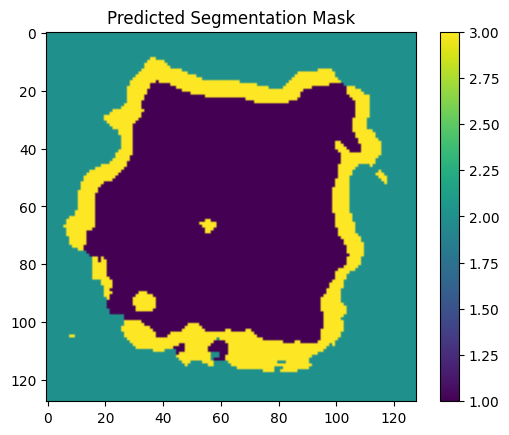

In [114]:
import matplotlib.pyplot as plt
predicted_class_map = torch.argmax(model_output[2], dim=0)  # Shape: [H, W]

# Convert to numpy and plot
plt.imshow(predicted_class_map.cpu().numpy())
plt.title("Predicted Segmentation Mask")
plt.colorbar()
plt.show()
#plt.imshow(model_output[0].detach().cpu().numpy())

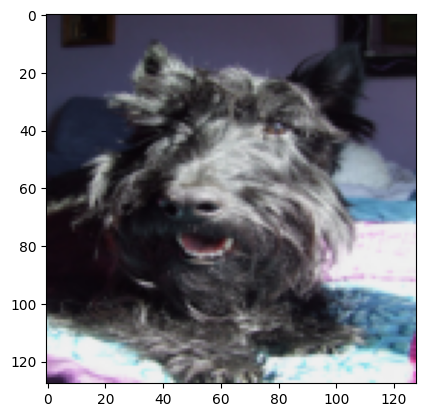

In [113]:
plt.imshow(image_batch[2].cpu().permute(1,2,0))

In [ ]:
|print(image_batch.shape)
print(labels.shape)

In [40]:
labels[0][64][64]

tensor(1)

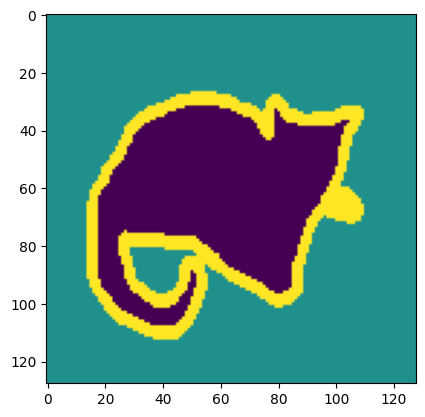

In [18]:
import matplotlib.pyplot as plt
plt.imshow(labels[0])